# Regime Classification Optimization

**Objective**: Improve the Regime Classification model to correctly identify 'Bull' market phases (Class 1). 
**Problem**: Previous iteration had 0.00 Recall for Class 1 due to severe class imbalance (80% Bear/Side vs 20% Bull).
**Approach**:
1.  Load Feature Data.
2.  Define Target (Same as before: 2% return in 24h).
3.  **Baseline**: Evaluate current XGBoost model.
4.  **Optimization**: 
    *   Apply Class Weights (`scale_pos_weight`).
    *   Compare with Random Forest (`class_weight='balanced'`).
    *   Compare with Logistic Regression, Extra Trees, and Gradient Boosting.
5.  **Validation**: Use Time-Series Cross-Validation to ensure robustness.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Set Project Root
project_root = Path('..').resolve()
sys.path.append(str(project_root))

# Load Data
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')
print(f"Data Shape: {df.shape}")

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m_features.csv...
Data Shape: (1534847, 42)


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1534847 entries, 2021-01-01 00:00:00 to 2023-12-31 14:27:00
Data columns (total 42 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Open                  1534847 non-null  float64
 1   High                  1534847 non-null  float64
 2   Low                   1534847 non-null  float64
 3   Close                 1534847 non-null  float64
 4   Volume                1534847 non-null  float64
 5   sma_7d                1524768 non-null  float64
 6   sma_30d               1491648 non-null  float64
 7   sma_90d               1405248 non-null  float64
 8   ema_7d                1524768 non-null  float64
 9   ema_21d               1504608 non-null  float64
 10  adx_14d               1534847 non-null  float64
 11  rsi_14d               1514688 non-null  float64
 12  rsi_30d               1491648 non-null  float64
 13  stoch_k_14d           1514688 non-null  float64
 14  s

## 1. Feature Preparation & Target Generation
We use the same logic as `integrated_strategy_v2.ipynb` but focus purely on the classification task.

In [ ]:
# Resample to 4H for Regime Classification
df_4h = df.resample('4h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'rsi_14d': 'last',
    'volatility_30d': 'last',
    'trend_sma_30d': 'last',
    'residual_diff_1d': 'last',
    'macd': 'last',
    'macd_signal': 'last',
    'macd_diff': 'last'
}).dropna() 

# --- Feature Engineering ---

# 1. Crossover Features (SMA 50 / EMA 20) on 4H data
df_4h['sma_50'] = df_4h['Close'].rolling(window=50).mean()
df_4h['ema_20'] = df_4h['Close'].ewm(span=20, adjust=False).mean()

# Interaction: 1 if EMA > SMA (Bullish), -1 if EMA < SMA (Bearish)
df_4h['cross_signal'] = np.where(df_4h['ema_20'] > df_4h['sma_50'], 1, -1)

# Define Target: 2% Return in next 24h (6 bars of 4H)
LOOKAHEAD_BARS = 6 # 24 hours
THRESHOLD = 0.02

df_4h['Future_Return'] = df_4h['Close'].shift(-LOOKAHEAD_BARS) / df_4h['Close'] - 1
df_4h['Target'] = (df_4h['Future_Return'] > THRESHOLD).astype(int)

# Drop NaNs (from rolling windows and shifting)
df_4h = df_4h.dropna()

print("Target Distribution:")
print(df_4h['Target'].value_counts(normalize=True))

# --- Standardization ---

# Features to Standardize (Relative / Stationary)
features_to_scale = ['rsi_14d', 'volatility_30d', 'residual_diff_1d', 'macd', 'macd_signal', 'macd_diff']

# Features to Keep Original (Time-sensitive / Absolute / Categorical)
features_no_scale = ['trend_sma_30d', 'cross_signal']

# Apply Standardization
scaler = StandardScaler()
df_4h[features_to_scale] = scaler.fit_transform(df_4h[features_to_scale])

# Combine Features
features = features_to_scale + features_no_scale
X = df_4h[features]
y = df_4h['Target']

print(f"Features used: {features}")
print(f"Data Shape after preprocessing: {X.shape}")

Target Distribution:
Target
0    0.792394
1    0.207606
Name: proportion, dtype: float64


## 2. Time-Series Cross-Validation Setup
We use `TimeSeriesSplit` to evaluate models on expanding windows, simulating real-world retraining.

In [9]:
def evaluate_model_cv(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    reports = []
    f1_scores = []
    
    print(f"Evaluating {model.__class__.__name__} with {n_splits} splits...")
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        reports.append(report)
        f1_scores.append(report['1']['f1-score'])
        
        print(f"Fold {fold+1}: Class 1 F1-Score: {report['1']['f1-score']:.4f} | Support: {report['1']['support']}")
        
    avg_f1 = np.mean(f1_scores)
    print(f"Average Class 1 F1-Score: {avg_f1:.4f}")
    return reports

## 3. Model Comparison
We compare:
1.  **XGBoost Baseline**: Default parameters (similar to previous failure).
2.  **XGBoost Weighted**: Using `scale_pos_weight` to balance classes.
3.  **Random Forest Balanced**: Using `class_weight='balanced'`.
4.  **Logistic Regression Balanced**: Linear baseline.
5.  **Extra Trees Balanced**: Low variance tree ensemble.
6.  **Gradient Boosting**: Standard boosting.

In [10]:
# Calculate Scale Pos Weight for XGBoost
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# 1. XGBoost Baseline
xgb_baseline = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
print("\n--- XGBoost Baseline ---")
evaluate_model_cv(xgb_baseline, X, y)

# 2. XGBoost Weighted
xgb_weighted = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, use_label_encoder=False)
print("\n--- XGBoost Weighted ---")
evaluate_model_cv(xgb_weighted, X, y)

# 3. Random Forest Balanced
rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
print("\n--- Random Forest Balanced ---")
evaluate_model_cv(rf_balanced, X, y)

# 4. Logistic Regression (Balanced)
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
print("\n--- Logistic Regression (Balanced) ---")
evaluate_model_cv(lr_balanced, X, y)

# 5. Extra Trees (Balanced)
et_balanced = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=42)
print("\n--- Extra Trees Balanced ---")
evaluate_model_cv(et_balanced, X, y)

# 6. Gradient Boosting (Standard)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
print("\n--- Gradient Boosting (Standard) ---")
evaluate_model_cv(gb_model, X, y)

Calculated scale_pos_weight: 3.82

--- XGBoost Baseline ---
Evaluating XGBClassifier with 5 splits...
Fold 1: Class 1 F1-Score: 0.2974 | Support: 269.0
Fold 2: Class 1 F1-Score: 0.3434 | Support: 234.0
Fold 3: Class 1 F1-Score: 0.1777 | Support: 166.0
Fold 4: Class 1 F1-Score: 0.0311 | Support: 186.0


c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actio

Fold 5: Class 1 F1-Score: 0.1256 | Support: 134.0
Average Class 1 F1-Score: 0.1950

--- XGBoost Weighted ---
Evaluating XGBClassifier with 5 splits...
Fold 1: Class 1 F1-Score: 0.2715 | Support: 269.0
Fold 2: Class 1 F1-Score: 0.3697 | Support: 234.0
Fold 3: Class 1 F1-Score: 0.1815 | Support: 166.0
Fold 4: Class 1 F1-Score: 0.0673 | Support: 186.0
Fold 5: Class 1 F1-Score: 0.1026 | Support: 134.0
Average Class 1 F1-Score: 0.1985

--- Random Forest Balanced ---
Evaluating RandomForestClassifier with 5 splits...


c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:15:59] WARNING: C:\actio

Fold 1: Class 1 F1-Score: 0.1983 | Support: 269.0
Fold 2: Class 1 F1-Score: 0.2901 | Support: 234.0
Fold 3: Class 1 F1-Score: 0.0000 | Support: 166.0
Fold 4: Class 1 F1-Score: 0.0000 | Support: 186.0
Fold 5: Class 1 F1-Score: 0.0111 | Support: 134.0
Average Class 1 F1-Score: 0.0999

--- Logistic Regression (Balanced) ---
Evaluating LogisticRegression with 5 splits...
Fold 1: Class 1 F1-Score: 0.3212 | Support: 269.0
Fold 2: Class 1 F1-Score: 0.3619 | Support: 234.0
Fold 3: Class 1 F1-Score: 0.2708 | Support: 166.0
Fold 4: Class 1 F1-Score: 0.0213 | Support: 186.0
Fold 5: Class 1 F1-Score: 0.2381 | Support: 134.0
Average Class 1 F1-Score: 0.2426

--- Extra Trees Balanced ---
Evaluating ExtraTreesClassifier with 5 splits...
Fold 1: Class 1 F1-Score: 0.2567 | Support: 269.0
Fold 2: Class 1 F1-Score: 0.3008 | Support: 234.0
Fold 3: Class 1 F1-Score: 0.0105 | Support: 166.0
Fold 4: Class 1 F1-Score: 0.0106 | Support: 186.0
Fold 5: Class 1 F1-Score: 0.1735 | Support: 134.0
Average Class 1 F1

[{'0': {'precision': 0.7312722948870393,
   'recall': 0.7774968394437421,
   'f1-score': 0.7536764705882353,
   'support': 791.0},
  '1': {'precision': 0.1963470319634703,
   'recall': 0.15985130111524162,
   'f1-score': 0.1762295081967213,
   'support': 269.0},
  'accuracy': 0.620754716981132,
  'macro avg': {'precision': 0.46380966342525476,
   'recall': 0.4686740702794919,
   'f1-score': 0.4649529893924783,
   'support': 1060.0},
  'weighted avg': {'precision': 0.5955223932583222,
   'recall': 0.620754716981132,
   'f1-score': 0.6071356848492567,
   'support': 1060.0}},
 {'0': {'precision': 0.7549194991055456,
   'recall': 0.5108958837772397,
   'f1-score': 0.6093862815884477,
   'support': 826.0},
  '1': {'precision': 0.1936127744510978,
   'recall': 0.41452991452991456,
   'f1-score': 0.2639455782312925,
   'support': 234.0},
  'accuracy': 0.48962264150943396,
  'macro avg': {'precision': 0.4742661367783217,
   'recall': 0.46271289915357716,
   'f1-score': 0.4366659299098701,
   '

## 4. Detailed Analysis of Best Model
Let's take the best performing model (likely Weighted XGB or RF) and analyze its predictions on the last fold in detail.


Final Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1108
           1       0.08      0.05      0.06       165

    accuracy                           0.81      1273
   macro avg       0.47      0.48      0.48      1273
weighted avg       0.76      0.81      0.78      1273



c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:16:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


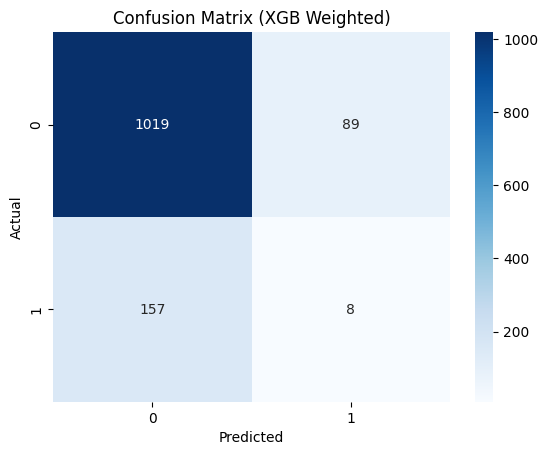

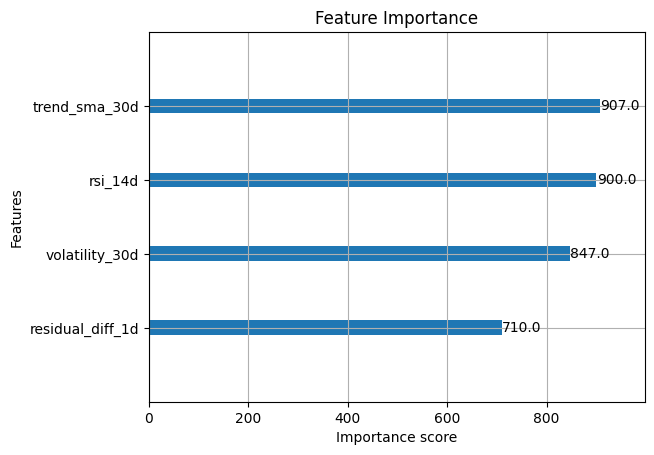

In [11]:
# Train Best Model on first 80% and test on last 20% (Simulating the final test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Using XGB Weighted as primary candidate (Replace with best performer if different)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nFinal Test Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (XGB Weighted)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

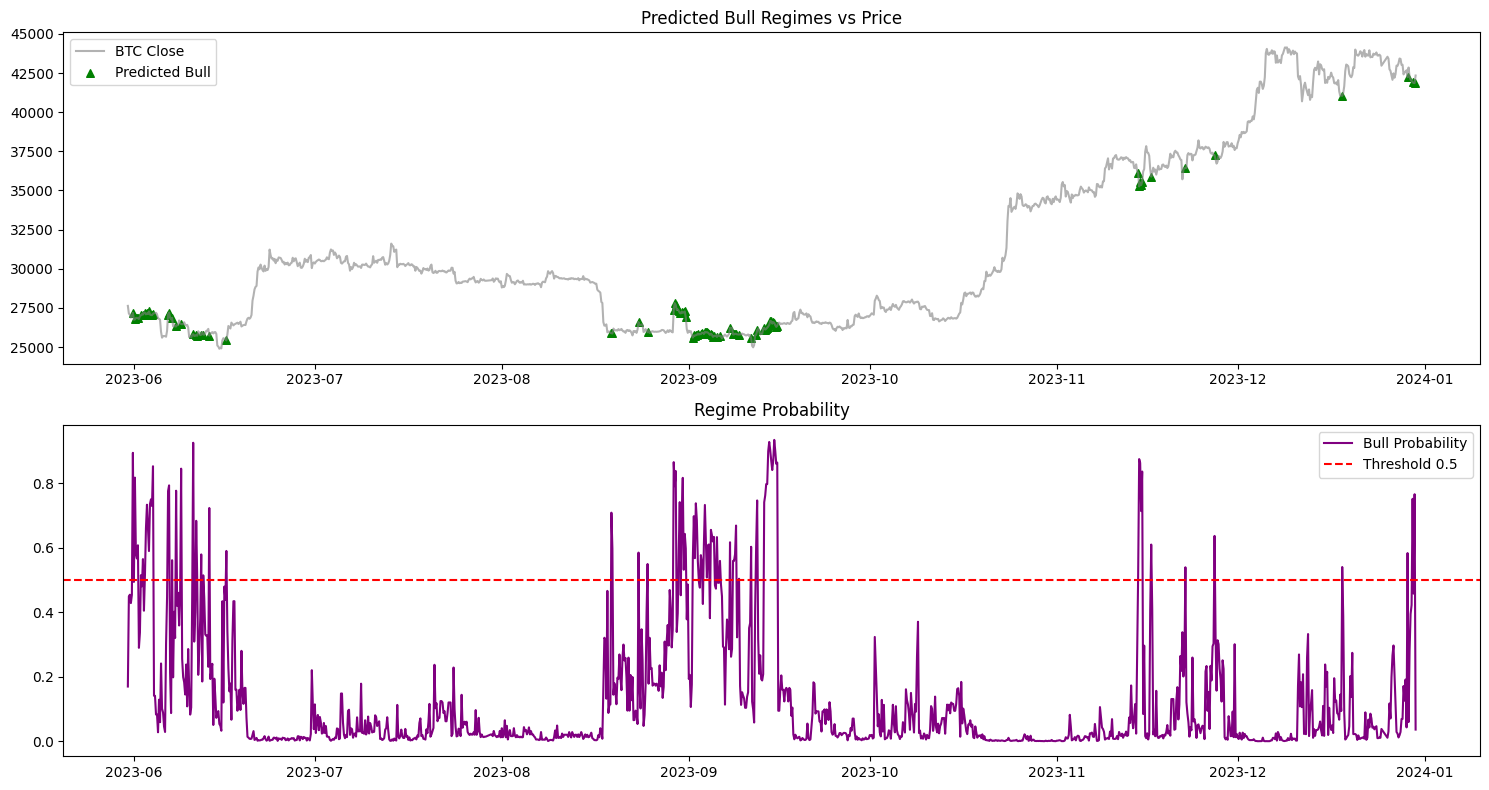

In [12]:
# Visualize Predictions vs Price
test_dates = df_4h.index[split_idx:]
price_test = df_4h['Close'].iloc[split_idx:]

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(test_dates, price_test, label='BTC Close', color='gray', alpha=0.6)
# Plot Bull Signals (Predicted Class 1)
bull_dates = test_dates[y_pred == 1]
bull_prices = price_test[y_pred == 1]
plt.scatter(bull_dates, bull_prices, color='green', label='Predicted Bull', marker='^', s=30)
plt.title('Predicted Bull Regimes vs Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_dates, y_prob, label='Bull Probability', color='purple')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.title('Regime Probability')
plt.legend()
plt.tight_layout()
plt.show()